<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#import-libs" data-toc-modified-id="import-libs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>import libs</a></span></li><li><span><a href="#set-parameters" data-toc-modified-id="set-parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>set parameters</a></span></li><li><span><a href="#Parse-Lammps-dump-file" data-toc-modified-id="Parse-Lammps-dump-file-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Parse Lammps dump file</a></span></li><li><span><a href="#Energy" data-toc-modified-id="Energy-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Energy</a></span><ul class="toc-item"><li><span><a href="#main()" data-toc-modified-id="main()-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>main()</a></span></li></ul></li><li><span><a href="#Train-NN" data-toc-modified-id="Train-NN-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train NN</a></span></li></ul></div>

# import libs

In [16]:
import configparser
confParser = configparser.ConfigParser()

#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())
#
import os
import sys
sys.path.append(confParser['input files']['lib_path'])
from dscribe.descriptors import SOAP, ACSF
import ase
import ase.io
import ase.build
from ase.io import lammpsdata
import pdb
import time
import numpy as np
import pandas as pd
import traceback
import matplotlib.pyplot as plt
if not eval(confParser['flags']['RemoteMachine']):
    plt.rc('text', usetex=True)
import sklearn
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from scipy.stats import gaussian_kde


#--- user modules
import LammpsPostProcess as lp
import utility as utl
import imp
imp.reload(utl)
imp.reload(lp)


conf. file sections: ['parameters', 'flags', 'MsdAnalysis', 'SroAnalysis', 'input files', 'EnergyBarrier', 'neural net', 'Atomic Radius']


<module 'LammpsPostProcess' from '../../HeaDef/postprocess/LammpsPostProcess.py'>

# Train NN

In [18]:
class NeuralNetwork():

    def __init__(self, verbose=False,
                **kwargs
                ):
        self.verbose = verbose
        for key in kwargs:
            setattr(self,key,kwargs[key])
    
    def Parse(self,path,nruns):
        descriptors = {}
        self.perAtomData = {}
        for irun in range(nruns):
            try:
                descriptors[irun]    = np.load('%s/Run%s/descriptors.npy'%(path,irun))
                data = np.loadtxt('%s/Run%s/perAtomData.txt'%(path,irun))
                self.perAtomData[irun] = pd.DataFrame(np.c_[data],
                columns='id	type	x	y	z	ux	uy	uz	energy_barrier	defect_label'.split()
                            )
            except:
                if self.verbose:
                    traceback.print_exc()
                continue
                
        
        self.nruns = list(self.perAtomData.keys())
        
        #--- same configurations
        self.descriptors = descriptors[self.nruns[0]]
        
    def Combine(self):
        
        #--- center atoms
        center_atom_indices = list(map(lambda x:NeuralNetwork.GetCenterAtom( self.perAtomData[x])[0],self.nruns))
        sdict = dict(zip(center_atom_indices,self.nruns))
        
        atom_ids = list(sdict.keys())
        #         center_atom_indices = list( set( center_atom_indices ) )
        data = np.concatenate(list(map(lambda x: np.c_[self.perAtomData[sdict[x]].iloc[ x ]],atom_ids)),axis=1).T
    
        #--- data frame
#        print(data.shape)
        irun = self.nruns[0]
        df_combined = pd.DataFrame(data,columns=list(self.perAtomData[irun].keys()))
    
        #--- filter crystaliine atoms
        filtr = self.perAtomData[irun].defect_label == 0.0
        df_crystalline = self.perAtomData[irun][filtr]
        
        #--- merge
        keys = list(df_combined.keys())
        data_concat = np.concatenate([np.c_[df_combined[keys]],np.c_[df_crystalline[keys]]],axis=0) 
        self.perAtomData = pd.DataFrame(data_concat,
                              columns=keys
                             )

        
        #--- filter descriptors
        filtr[atom_ids] = True
        self.descriptors = self.descriptors[filtr]
        
        assert self.perAtomData.shape[ 0 ] == self.descriptors.shape[0], 'need more mc swaps: %s %s'\
        %(self.perAtomData.shape[ 0 ],self.descriptors.shape[0])
                            
                                 
    
    @staticmethod
    def GetCenterAtom(df):
        disp_magnitude = df.ux**2+df.uy**2+df.uz**2
        center_atom_indx = disp_magnitude.sort_values(ascending=False).index[0]
        return center_atom_indx, int(df.iloc[ center_atom_indx ].id)

    @staticmethod
    def zscore(slist):
        tmp = np.copy(slist)
        print(np.mean(tmp),np.std(tmp))
        tmp -= np.mean(tmp)
        tmp /= np.std(tmp)
        return tmp

    def PCA(self,
           n_components=2,
            random_state = 1,
           ):
        #--- concat. data
        X = self.descriptors
        pca = PCA(n_components=n_components,random_state=random_state)
        pca.fit(X)
        X_transformed = pca.transform(X)

        xdata = X_transformed[:,0]
        ydata = X_transformed[:,1]
        #
        filtr_defects = self.perAtomData.defect_label == 0.0
        #

        legend = utl.Legends()
        legend.Set(bbox_to_anchor=(1.1,.5, 0.5, 0.5))
#         pdb.set_trace()
        #ax = utl.PltErr(zscore(xdata)[filtr_defects],zscore(ydata)[filtr_defects],
        ax = utl.PltErr(xdata[filtr_defects],ydata[filtr_defects],
                  attrs={'fmt':'x','alpha':1,'label':'defect_free'},
                        Plot = False,
        #                 xlim=(-2,2),
        #                 ylim=(-2,2),
                  )

        #utl.PltErr(zscore(xdata)[~filtr_defects],zscore(ydata)[~filtr_defects],
        !mkdir png
        utl.PltErr(xdata[~filtr_defects],ydata[~filtr_defects],
                  attrs={'fmt':'.','color':'red','label':'defects'},
                   ax=ax,
                   xstr='pca_1',ystr='pca_2',
                   legend = legend.Get(),
                   title='png/pca.png'
                  )
    def Spectra(self,
               nrows=100,
               ):
        assert nrows <= self.descriptors.shape[ 0 ]
        !mkdir png
        utl.PltBitmap(np.log10(np.abs(self.descriptors[:nrows,:])),
                      xlabel=r'$\mathrm{ndim}$',ylabel=r'$\mathrm{natom}$',
                      xlim=(0,self.descriptors.shape[1]),
                      ylim=(0,nrows),
                      colorbar=True,
                      zscore=False,
                      vminmax=(-3,3),
                      title='png/feature_bitmap.png'
                     )
        
    def TrainClassifier(self,y,
                       random_state=1,
                       ):
        #--- train-test split
        X = np.c_[self.descriptors]
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                            random_state=random_state)

        #--- tune parameters
        param_grid = {
                        'hidden_layer_sizes':[(100,100)],
        #                 'activation' : ['tanh', 'relu'],
                         'learning_rate_init':[1e-4],
        #                'alpha':[1e-4,1e-3,1e-2], #--- regularization 
        #               'learning_rate' : ['invscaling', 'adaptive'],

                     } 

        #--- train
        mlp = MLPClassifier(random_state=random_state)
        clf = GridSearchCV(mlp, param_grid)
        clf.fit(X_train,y_train)

        #--- validate
        !mkdir png
        utl.PltErr(range(len(clf.best_estimator_.loss_curve_)), clf.best_estimator_.loss_curve_,
                   yscale='log',
                   xstr='epoch',ystr='loss',
                   title='png/loss.png',
                  )


        #--- confusion matrix
        cm = confusion_matrix(y_test, clf.predict(X_test),
                         labels=[0, 1]
                        )
        print('cm=',cm)

    def TrainRegressor(self,stratify,y,
                       random_state=1,
                       printOvito = False,
                       filtr = None,
                       ):
        if self.verbose:
            print('dim(y)=',y.shape)
        #--- train-test split
        X = np.c_[self.descriptors[filtr]]
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=stratify,
                                                            random_state=random_state)
#        pdb.set_trace()
        #--- tune parameters
        param_grid = {
                        'hidden_layer_sizes':self.hidden_layer_sizes,
 #                        'activation' : ['tanh', 'relu'],
                         'learning_rate_init':self.learning_rate_init,
        #                'alpha':[1e-4,1e-3,1e-2], #--- regularization 
        #               'learning_rate' : ['invscaling', 'adaptive'],

                     } 

        #--- train
        mlp = MLPRegressor(random_state=random_state,verbose=self.verbose)
        clf = GridSearchCV(mlp, param_grid)
        clf.fit(X_train,y_train)

        #--- validate
        !mkdir png
        utl.PltErr(range(len(clf.best_estimator_.loss_curve_)), clf.best_estimator_.loss_curve_,
                   yscale='log',
                   xstr='epoch',ystr='loss',
                   title='png/loss.png',
                  )

#         pdb.set_trace()
        y_pred = clf.best_estimator_.predict(X_test)        
        y_pred_train = clf.best_estimator_.predict(X_train)        
        for idime, xstr in zip(range(3),'ux uy uz'.split()):
            ax = utl.PltErr(None,None,Plot=False)
            #
#             utl.PltErr(y_test[:,idime],y_pred[:,idime],
#                        attrs={'fmt':'x','color':'red','zorder':10,'markersize':6},
#                        ax=ax,
#                        Plot = False,

#                       )
            #
            utl.PltErr(y_train[:,idime],y_pred_train[:,idime],
                       attrs={'fmt':'.','color':'blue','zorder':1,'markersize':6},
                       ax=ax,
                       Plot = False,

                      )
            #
            utl.PltErr(None,None,Plot=False,
                           title='png/scatter%s.png'%idime,
                            ax=ax,
                       xstr='%s actual'%xstr,ystr='%s predicted'%xstr,
                       xlim=(-2,2),ylim=(-2,2),
                           )
            
        if printOvito:
            X_train, X_test, _, _ = train_test_split(self.perAtomData[filtr]['id type x y z'.split()], y, stratify=stratify,
                                                    random_state=random_state)
#            pdb.set_trace()
            with open('original.xyz','w') as fp:
                utl.PrintOvito(self.perAtomData[filtr], fp, '0', attr_list='id type x y z ux uy uz'.split())
            with open('train.xyz','w') as fp:
                cordc = pd.DataFrame(np.c_[X_train,y_pred_train],columns='id type x y z ux uy uz'.split())
                utl.PrintOvito(cordc, fp, '0', attr_list='id type x y z ux uy uz'.split())



## main()

,id,type,x,y,z,ux,uy,uz,energy_barrier,defect_label
0,11573.0,1.0,23.385145,14.492855,2.124000,1.726816,-1.726792e+00,7.152557e-07,0.996834,1.0
1,9426.0,1.0,26.882855,14.492855,2.124000,-1.726812,-1.726816e+00,-4.768372e-06,0.996806,1.0
2,15694.0,1.0,23.385145,10.995145,2.124000,1.726835,1.726784e+00,-6.914139e-06,0.996819,1.0
3,7235.0,1.0,25.134001,14.492855,0.375145,-0.000006,-1.725982e+00,1.725976e+00,0.996802,1.0
4,17966.0,1.0,23.385145,12.744001,3.872855,1.726807,9.536743e-07,-1.726816e+00,0.996822,1.0
5,7637.0,1.0,26.882855,10.995145,2.124000,-1.726803,1.726815e+00,-6.675720e-06,0.996819,1.0
6,6456.0,1.0,25.134001,10.995145,0.375145,0.000000,1.726811e+00,1.726811e+00,0.996820,1.0
7,600.0,1.0,26.882855,12.744001,3.872855,-1.726814,3.814697e-06,-1.726806e+00,0.996820,1.0
8,1282.0,1.0,25.134001,14.492855,3.872855,0.000002,-1.726806e+00,-1.726816e+00,0.996807,1.0
9,9020.0,1.0,23.385145,12.744001,0.375145,1.726788,-3.814697e-06,1.726823e+00,0.996844,1.0


dim(y)= (19649, 3)
Iteration 1, loss = 20.31239674
Iteration 2, loss = 0.04239722
Iteration 3, loss = 0.00147534
Iteration 4, loss = 0.00136278
Iteration 5, loss = 0.00142207
Iteration 6, loss = 0.00131453
Iteration 7, loss = 0.00129030
Iteration 8, loss = 0.00127515
Iteration 9, loss = 0.00124831
Iteration 10, loss = 0.00122926
Iteration 11, loss = 0.00120159
Iteration 12, loss = 0.00119914
Iteration 13, loss = 0.00115853
Iteration 14, loss = 0.00114088
Iteration 15, loss = 0.00112657
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 20.31820970
Iteration 2, loss = 0.04300857
Iteration 3, loss = 0.00152525
Iteration 4, loss = 0.00140589
Iteration 5, loss = 0.00148190
Iteration 6, loss = 0.00134328
Iteration 7, loss = 0.00130807
Iteration 8, loss = 0.00127899
Iteration 9, loss = 0.00125348
Iteration 10, loss = 0.00123539
Iteration 11, loss = 0.00120815
Iteration 12, loss = 0.00126931
Iteration 13, loss = 0.00117617
Iteration 1

Iteration 32, loss = 0.00255902
Iteration 33, loss = 0.00199330
Iteration 34, loss = 0.00171307
Iteration 35, loss = 0.00157769
Iteration 36, loss = 0.00151419
Iteration 37, loss = 0.00148517
Iteration 38, loss = 0.00147206
Iteration 39, loss = 0.00146638
Iteration 40, loss = 0.00146376
Iteration 41, loss = 0.00146256
Iteration 42, loss = 0.00146190
Iteration 43, loss = 0.00146137
Iteration 44, loss = 0.00146106
Iteration 45, loss = 0.00146072
Iteration 46, loss = 0.00146027
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 278.66351898
Iteration 2, loss = 229.78438541
Iteration 3, loss = 188.08145476
Iteration 4, loss = 152.74825424
Iteration 5, loss = 123.00603800
Iteration 6, loss = 98.14766632
Iteration 7, loss = 77.53406955
Iteration 8, loss = 60.59153697
Iteration 9, loss = 46.80435713
Iteration 10, loss = 35.70853007
Iteration 11, loss = 26.88680243
Iteration 12, loss = 19.96471471
Iteration 13, loss = 14.60964348
Itera

Iteration 4, loss = 256.47976959
Iteration 5, loss = 102.20323414
Iteration 6, loss = 35.45006182
Iteration 7, loss = 10.73458408
Iteration 8, loss = 2.86569746
Iteration 9, loss = 0.66555115
Iteration 10, loss = 0.13485558
Iteration 11, loss = 0.02422150
Iteration 12, loss = 0.00426789
Iteration 13, loss = 0.00115550
Iteration 14, loss = 0.00073648
Iteration 15, loss = 0.00068806
Iteration 16, loss = 0.00068274
Iteration 17, loss = 0.00068170
Iteration 18, loss = 0.00068100
Iteration 19, loss = 0.00068036
Iteration 20, loss = 0.00067962
Iteration 21, loss = 0.00067902
Iteration 22, loss = 0.00067826
Iteration 23, loss = 0.00067757
Iteration 24, loss = 0.00067684
Iteration 25, loss = 0.00067613
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2154.39204546
Iteration 2, loss = 1160.86595270
Iteration 3, loss = 573.53609378
Iteration 4, loss = 256.45049967
Iteration 5, loss = 102.18743829
Iteration 6, loss = 35.44343338
Iterati

Iteration 10, loss = 1643.22097763
Iteration 11, loss = 1546.99662099
Iteration 12, loss = 1455.12182475
Iteration 13, loss = 1367.44607571
Iteration 14, loss = 1283.82129046
Iteration 15, loss = 1204.10600774
Iteration 16, loss = 1128.17727047
Iteration 17, loss = 1055.90885246
Iteration 18, loss = 987.16453423
Iteration 19, loss = 921.82683068
Iteration 20, loss = 859.78447670
Iteration 21, loss = 800.89831407
Iteration 22, loss = 745.05205382
Iteration 23, loss = 692.13843150
Iteration 24, loss = 642.06278818
Iteration 25, loss = 594.83694786
Iteration 26, loss = 550.27833819
Iteration 27, loss = 508.24246303
Iteration 28, loss = 468.63102782
Iteration 29, loss = 431.35422538
Iteration 30, loss = 396.36758264
Iteration 31, loss = 363.55028532
Iteration 32, loss = 332.98640862
Iteration 33, loss = 304.62096559
Iteration 34, loss = 278.09869677
Iteration 35, loss = 253.33436682
Iteration 36, loss = 230.25205556
Iteration 37, loss = 208.77907527
Iteration 38, loss = 188.84322492
Iterat

Iteration 43, loss = 109.79609563
Iteration 44, loss = 97.63778511
Iteration 45, loss = 86.54498663
Iteration 46, loss = 76.45437135
Iteration 47, loss = 67.30429833
Iteration 48, loss = 59.03413807
Iteration 49, loss = 51.58498883
Iteration 50, loss = 44.89939582
Iteration 51, loss = 38.92147593
Iteration 52, loss = 33.59735494
Iteration 53, loss = 28.87492416
Iteration 54, loss = 24.70617673
Iteration 55, loss = 21.08528282
Iteration 56, loss = 17.92918905
Iteration 57, loss = 15.17173412
Iteration 58, loss = 12.77352189
Iteration 59, loss = 10.69820448
Iteration 60, loss = 8.91155470
Iteration 61, loss = 7.38171066
Iteration 62, loss = 6.07908806
Iteration 63, loss = 4.97633371
Iteration 64, loss = 4.04839884
Iteration 65, loss = 3.27244932
Iteration 66, loss = 2.62773886
Iteration 67, loss = 2.09570678
Iteration 68, loss = 1.65962397
Iteration 69, loss = 1.30475228
Iteration 70, loss = 1.01811682
Iteration 71, loss = 0.78833178
Iteration 72, loss = 0.60557441
Iteration 73, loss = 0

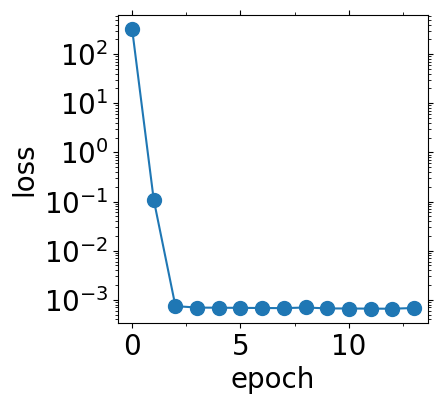

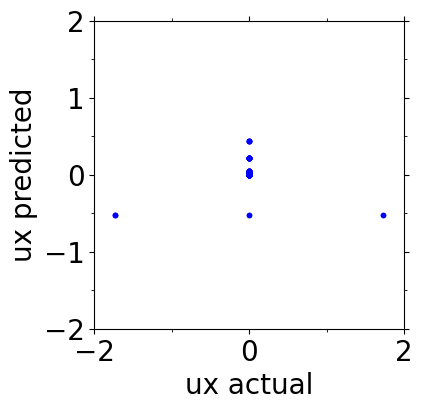

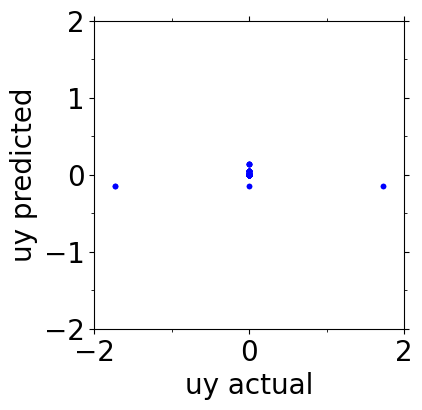

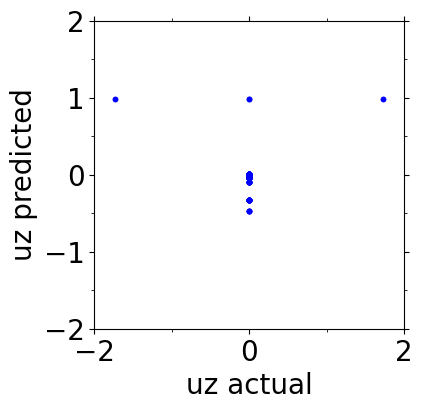

In [19]:
 def main():
        
    nn = NeuralNetwork(
                        hidden_layer_sizes = eval(confParser['neural net']['hidden_layer_sizes']),
                        learning_rate_init = eval(confParser['neural net']['learning_rate_init']),
#                         verbose=True
    )
    nn.Parse(path=confParser['neural net']['input_path'],
             nruns=eval(confParser['neural net']['nruns']))
    nn.Combine()
#     tmp = nn.df_combined.set_index('id')
    display(nn.perAtomData.iloc[:13])
    #    
#    nn.PCA()
#    nn.Spectra()
#    nn.TrainClassifier(np.c_[nn.perAtomData.defect_label].astype(int))
    filtr = nn.perAtomData.defect_label >= 0.0 #== 1.0
    nn.TrainRegressor( stratify=np.c_[nn.perAtomData.defect_label].astype(int),
                        y=np.c_[nn.perAtomData[filtr]['ux uy uz'.split()]],
                      printOvito = True,
                      filtr=filtr,
                     )
    
main()

In [ ]:
# ax = utl.PltErr(None,None,Plot=False)

# for i in range(11):
#     utl.PltErr(range(nn.descriptors[0,:].shape[0]),nn.descriptors[i,:],
#               attrs={'fmt':'-'},#,'color':'C0'},
#                xscale='log',yscale='log',
#                ax=ax,
#                Plot=False,
#               )



In [ ]:
# nn.Spectra(nrows=100)